In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ref implementation

In [2]:
from sklearn import tree, metrics

In [3]:
df_train = pd.read_csv("https://raw.githubusercontent.com/Cuongvn08/tensorflow_kaggle_house_price/master/data/train.csv")

X = df_train[['OverallQual', 'GrLivArea', 'GarageCars']]
y = df_train['SalePrice']

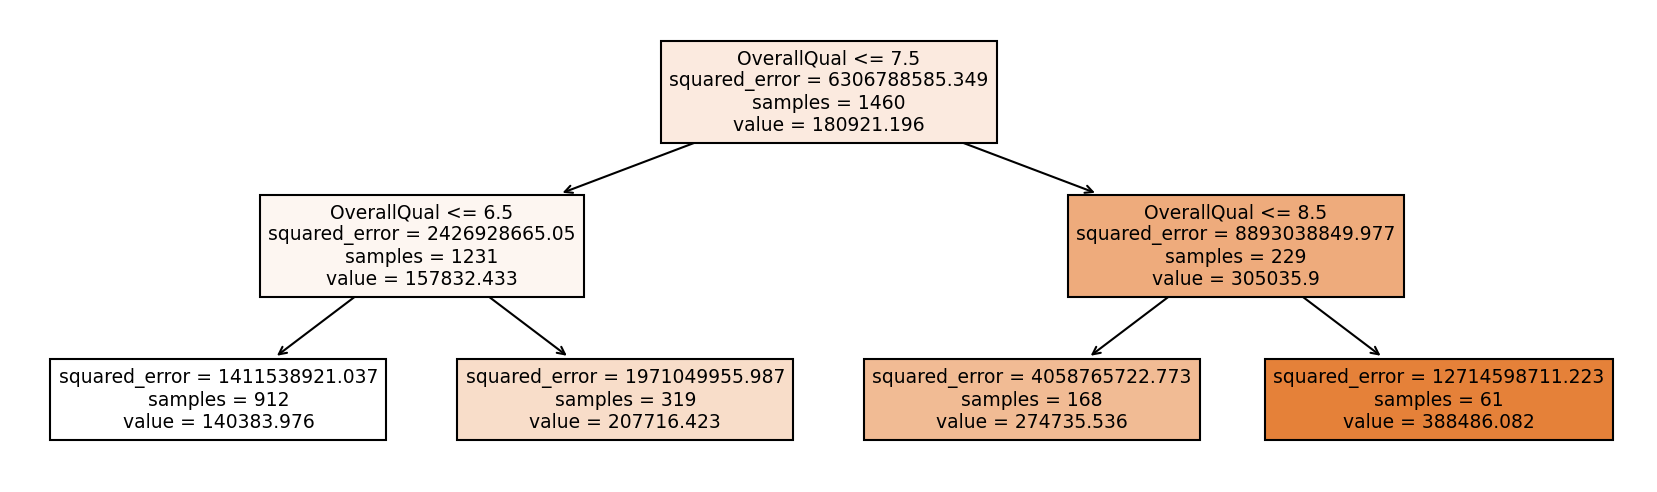

In [4]:
reg = tree.DecisionTreeRegressor(max_depth=2)
reg.fit(X, y)

plt.figure(figsize=(14,4),dpi=150)
tree.plot_tree(reg, fontsize=9, feature_names=X.columns, filled=True);

In [5]:
preds = reg.predict(X)
print('r2',metrics.r2_score(y, preds))
print('rmse',metrics.mean_squared_error(y, preds, squared=False))

r2 0.6336246655552089
rmse 48069.23940764968


# Tree

In [30]:
class Leaf:
    def __init__(self, label, observations):
        self.label = label
        self.observations = observations
        
    def predict(self, X):
        return np.full(X.shape[0], self.label)
    
    def __repr__(self):
        return f'Leaf: value = {self.label} obs = {self.observations}'
        

class Node:
    def __init__(self, split_dim, split_value, left_tree, right_tree, depth):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left_tree = left_tree
        self.right_tree = right_tree
        self.depth = depth
        
    def predict(self, X):
        predictions = np.empty(X.shape[0])
        left_mask = X[:, self.split_dim] <= self.split_value
        right_mask = X[:, self.split_dim] > self.split_value
        predictions[left_mask] = self.left_tree.predict(X[left_mask])
        predictions[right_mask] = self.right_tree.predict(X[right_mask])
        return predictions
    
    def __repr__(self):
        return f'''Node (split_dim = {self.split_dim}, split_val = {self.split_value})
  {" "*2*self.depth}Left: {repr(self.left_tree)}
  {" "*2*self.depth}Right: {repr(self.right_tree)}'''
        

class RegressionTree:
    def __init__(self, max_depth=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        assert X.shape[0] == len(y)
        self.n_dims = X.shape[1]
        self.n_observations = X.shape[0]
        self._tree = self.build_tree(np.arange(self.n_observations), 0)
        
    def predict(self, X):
        return self._tree.predict(X)
        
    def loss(self, y, y_hat):
        return np.sum((y - y_hat)**2)
        
    def split_loss(self, left_y, right_y):
        # print(f'    left_y={left_y} left_y_bar={left_y.mean()}')
        # print(f'    right_y={right_y} right_y_bar={right_y.mean()}')
        # left_loss = self.loss(left_y, left_y.mean())
        # right_loss = self.loss(right_y, right_y.mean())
        # print(f'    left_loss={left_loss} right_loss={right_loss}')
        return self.loss(left_y, left_y.mean()) + self.loss(right_y, right_y.mean())

    def build_tree(self, observations_idxs, depth):
        #print(f'depth={depth} obs_idxs_size = {len(observations_idxs)} ob_idxs = {observations_idxs[:5]}')
        if depth >= self.max_depth or len(observations_idxs) <= self.min_samples_leaf:
            leaf = Leaf(self.y[observations_idxs].mean(), len(observations_idxs))
            #print(f'Created leaf: {leaf}!\n')
            return leaf
        else:
            best_split_dim = None
            best_split_val = None
            best_split_loss = np.Inf
            
            for dim in range(self.n_dims):
                feature_vals = self.X[observations_idxs, dim]
                for split_val in feature_vals:
                    left_idxs = observations_idxs[feature_vals <= split_val]
                    right_idxs = observations_idxs[feature_vals > split_val]
                    
                    if left_idxs.size < self.min_samples_leaf or right_idxs.size < self.min_samples_leaf: 
                        continue
                        
                    loss = self.split_loss(self.y[left_idxs], self.y[right_idxs])
                    #print(f'  dim={dim} val={split_val} loss={loss}')
                    
                    if loss < best_split_loss:
                        best_split_dim = dim
                        best_split_val = split_val
                        best_split_loss = loss
            if best_split_dim is None:
                #print("Couldn't split the data!")
                return Leaf(self.y[observations_idxs].mean(), len(observations_idxs))
            #print(f'Best split dim: {best_split_dim}, split val: {best_split_val}, split loss: {best_split_loss}\n')
            left_idxs = observations_idxs[self.X[observations_idxs, best_split_dim] <= best_split_val]
            right_idxs = observations_idxs[self.X[observations_idxs, best_split_dim] > best_split_val]
            return Node(best_split_dim, best_split_val, self.build_tree(left_idxs, depth+1), self.build_tree(right_idxs, depth+1), depth)

In [31]:
tree = RegressionTree(max_depth=2)

In [32]:
tree.fit(X.values, y.values)

In [33]:
tree._tree

Node (split_dim = 0, split_val = 7)
  Left: Node (split_dim = 0, split_val = 6)
    Left: Leaf: value = 140383.97587719298 obs = 912
    Right: Leaf: value = 207716.42319749217 obs = 319
  Right: Node (split_dim = 0, split_val = 8)
    Left: Leaf: value = 274735.53571428574 obs = 168
    Right: Leaf: value = 388486.08196721313 obs = 61

In [34]:
y_pred = tree.predict(X.values)

In [35]:
print('r2',metrics.r2_score(y, y_pred))
print('rmse',metrics.mean_squared_error(y, y_pred, squared=False))

r2 0.6336246655552089
rmse 48069.23940764968


In [25]:
tree = RegressionTree(max_depth=10, min_samples_leaf=5)

In [26]:
tree.fit(X.values, y.values)

In [28]:
y_pred = tree.predict(X.values)

In [29]:
print('r2',metrics.r2_score(y, y_pred))
print('rmse',metrics.mean_squared_error(y, y_pred, squared=False))

r2 0.8518431539090605
rmse 30567.85739576279


# Test

In [216]:
data = np.asarray([
    [-1, 3, 0],
    [1, 2, 0],
    [2, 1, 5],
    [2, 3, 5],
    [2, 5, 0],
    [3, 4, 0],
    [4, 1, 5],
    [4, 3, 5],
    [4, 4, 0],
    [5, 1, 0],
    [5, 3, 0]
])
X = data[:, :2]
y = data[:, 2]
X, y

(array([[-1,  3],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2,  5],
        [ 3,  4],
        [ 4,  1],
        [ 4,  3],
        [ 4,  4],
        [ 5,  1],
        [ 5,  3]]),
 array([0, 0, 5, 5, 0, 0, 5, 5, 0, 0, 0]))

In [217]:
tree = RegressionTree(max_depth=10, min_samples_leaf=2)

In [218]:
tree.fit(X, y)

depth=0 obs_idxs_size = 11 ob_idxs = [0 1 2 3 4]
depth=1 obs_idxs_size = 8 ob_idxs = [0 1 2 3 6]
depth=2 obs_idxs_size = 2 ob_idxs = [0 1]
depth=2 obs_idxs_size = 6 ob_idxs = [2 3 6 7 9]
depth=3 obs_idxs_size = 4 ob_idxs = [2 3 6 7]
depth=4 obs_idxs_size = 2 ob_idxs = [2 3]
depth=4 obs_idxs_size = 2 ob_idxs = [6 7]
depth=3 obs_idxs_size = 2 ob_idxs = [ 9 10]
depth=1 obs_idxs_size = 3 ob_idxs = [4 5 8]


In [219]:
tree._tree

Node (split_dim = 1, split_val = 3)
  Left:   Node (split_dim = 0, split_val = 1)
    Left: Leaf: value = 0.0 obs = 2
    Right:     Node (split_dim = 0, split_val = 4)
      Left:       Node (split_dim = 0, split_val = 2)
        Left: Leaf: value = 5.0 obs = 2
        Right: Leaf: value = 5.0 obs = 2
      Right: Leaf: value = 0.0 obs = 2
  Right: Leaf: value = 0.0 obs = 3

In [220]:
tree.predict(X)

array([0., 0., 5., 5., 0., 0., 5., 5., 0., 0., 0.])

In [221]:
y

array([0, 0, 5, 5, 0, 0, 5, 5, 0, 0, 0])